In [1]:
from tqdm import tqdm
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from datasets import load_dataset, DatasetDict, Dataset
from tokenizers import Tokenizer, models, trainers

dataset = load_dataset("sentence-transformers/parallel-sentences-wikimatrix", "en-zh")

assert isinstance(dataset, DatasetDict)

Using the latest cached version of the dataset since sentence-transformers/parallel-sentences-wikimatrix couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'en-zh' at C:\Users\karis\.cache\huggingface\datasets\sentence-transformers___parallel-sentences-wikimatrix\en-zh\0.0.0\74a4cb15422cdd0c3aacc93593b6cb96a9b9b3a9 (last modified on Sun Mar 30 22:09:32 2025).


In [3]:
def dataset_processing(dataset: Dataset, en_vocab_size: int, zh_vocab_size: int, min_frequency: int = 10):
    def chinese_rule(code: int):
        return code < 128 or 0x4E00 <= code <= 0x9FFF or 0x3000 <= code <= 0x303F or 0xFF01 <= code <= 0xFF5E

    def english_rule(code: int):
        return code < 128 or 0x3000 <= code <= 0x303F or 0xFF01 <= code <= 0xFF5E

    en_list = []
    zh_list = []
    for data in tqdm(dataset, desc="pre-processing"):
        en = data["english"]
        zh = data["non_english"]
        if all([english_rule(ord(c)) for c in en]) and all([chinese_rule(ord(c)) for c in zh]):
            en_list.append(en)
            zh_list.append(zh)

    print(f"训练文本长度: {len(en_list)}")

    special_tokens = ["[PAD]", "[UNK]", "[BOS]", "[EOS]"]
    continuing_subword_prefix = "##"
    # 英文分词器
    en_tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
    en_trainer = trainers.WordPieceTrainer(
        vocab_size=en_vocab_size,
        min_frequency=min_frequency,
        special_tokens=special_tokens + [".", ",", "!", "?", ";", ":"],
        continuing_subword_prefix=continuing_subword_prefix,
    )
    en_tokenizer.train_from_iterator(en_list, trainer=en_trainer)
    # 中文分词器
    zh_tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
    zh_trainer = trainers.WordPieceTrainer(
        vocab_size=zh_vocab_size,
        min_frequency=min_frequency,
        special_tokens=special_tokens + [".", ",", "!", "?", ";", ":"] + [chr(i) for i in range(0x3000, 0x303F)],
        continuing_subword_prefix=continuing_subword_prefix,
    )
    zh_tokenizer.train_from_iterator(zh_list, trainer=zh_trainer)
    # 处理文本编码

    en_vocab = en_tokenizer.get_vocab()
    zh_vocab = zh_tokenizer.get_vocab()
    assert en_vocab["[PAD]"] == zh_vocab["[PAD]"] == 0
    assert en_vocab["[UNK]"] == zh_vocab["[UNK]"] == 1
    assert en_vocab["[BOS]"] == zh_vocab["[BOS]"] == 2
    assert en_vocab["[EOS]"] == zh_vocab["[EOS]"] == 3

    en_dataset = [[2] + en_tokenizer.encode(en).ids + [3] for en in en_list]
    zh_dataset = [[2] + zh_tokenizer.encode(zh).ids + [3] for zh in zh_list]
    return en_tokenizer, zh_tokenizer, en_dataset, zh_dataset


en_tokenizer, zh_tokenizer, en_dataset, zh_dataset = dataset_processing(dataset["train"], 10000, 20000)

pre-processing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113408/113408 [00:03<00:00, 31126.42it/s]


训练文本长度: 89457


In [4]:
print(en_tokenizer.get_vocab_size())
print(zh_tokenizer.get_vocab_size())
print(en_tokenizer.decode(en_dataset[0]))
print(zh_tokenizer.decode(zh_dataset[0]))

10000
20000
This  ##un ##preced ##ented  ##development  ##became  ##attribut ##ed to the  ##Mor ##gan ##  ##banking  ##sty ##le
这种 ##前 ##所 ##未 ##有的 ##发展 ##被 ##归 ##结 ##于 ##摩 ##根 ##的 ##银行 ##风格


In [5]:
from torch.nn.utils.rnn import pad_sequence


def batch_processing(dataset: list[list[int]], batch_size: int, device=DEVICE):
    return [
        pad_sequence([torch.tensor(x, dtype=torch.long, device=device) for x in dataset[i : i + batch_size]], batch_first=True)
        for i in range(0, len(dataset), batch_size)
    ]


en_dataset = batch_processing(en_dataset, 32)
zh_dataset = batch_processing(zh_dataset, 32)
train_dataset = list(zip(en_dataset, zh_dataset))

In [6]:
print(en_tokenizer.decode(en_dataset[0][0].tolist()))
print(zh_tokenizer.decode(zh_dataset[0][0].tolist()))

This  ##un ##preced ##ented  ##development  ##became  ##attribut ##ed to the  ##Mor ##gan ##  ##banking  ##sty ##le
这种 ##前 ##所 ##未 ##有的 ##发展 ##被 ##归 ##结 ##于 ##摩 ##根 ##的 ##银行 ##风格


In [7]:
class EN_to_ZH(torch.nn.Module):
    def __init__(
        self,
        en_tokenizer: Tokenizer,
        zh_tokenizer: Tokenizer,
        emb_size: int,
        hidden_size: int,
        num_layers: int,
        dropout: float = 0,
        teacher_forcing_ratio: float = 0.5,
    ):
        super().__init__()
        self.en_tokenizer = en_tokenizer
        self.zh_tokenizer = zh_tokenizer
        input_vs = en_tokenizer.get_vocab_size()
        output_vs = zh_tokenizer.get_vocab_size()
        self.bos_ind = zh_tokenizer.token_to_id("[BOS]")
        self.eos_ind = zh_tokenizer.token_to_id("[EOS]")
        self.encoder_emb = torch.nn.Embedding(input_vs, emb_size)
        self.encoder_lstm = torch.nn.LSTM(emb_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.decoder_emb = torch.nn.Embedding(output_vs, hidden_size)
        self.decoder_lstm = torch.nn.LSTM(hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.lm = torch.nn.Linear(hidden_size, output_vs)
        self.num_layers = num_layers
        self.teacher_forcing_ratio = torch.tensor(teacher_forcing_ratio)

    def forward(self, source: torch.Tensor, target: torch.Tensor):
        embed_source: torch.Tensor = self.encoder_emb(source)
        encoder_hiddens = []
        state = None
        for x in embed_source.unbind(1):
            _, (hidden, cell) = self.encoder_lstm(x.unsqueeze(1), state)
            state = (hidden, cell)
            encoder_hiddens.append(hidden)
        encoded = torch.stack(encoder_hiddens, dim=-2)
        encoded_trans = torch.transpose(encoded, -2, -1)
        sqrtT: float = encoded_trans.size(-1) ** 0.5
        embed_target: torch.Tensor = self.decoder_emb(target)
        x = embed_target[:, 0].unsqueeze(1)
        outputs = []
        for target_t in embed_target.unbind(1):
            scores = x.unsqueeze(0) @ encoded_trans
            scores = torch.softmax(scores / sqrtT, dim=-1)
            hidden = scores @ encoded
            output, (hidden, cell) = self.decoder_lstm(x, (hidden.squeeze(-2), cell))
            output = self.lm(output)
            outputs.append(output)
            if torch.rand(1) < self.teacher_forcing_ratio:
                x = target_t.unsqueeze(1)
            else:
                x = self.decoder_emb(torch.argmax(output, dim=-1))
        return torch.cat(outputs, 1)

    def translate(self, inputs: str, device=DEVICE, max_len_ratio=2.0):
        source = torch.tensor(self.en_tokenizer.encode(inputs).ids, dtype=torch.long, device=device).unsqueeze(0)
        embed_source: torch.Tensor = self.encoder_emb(source)
        encoder_hiddens = []
        state = None
        for x in embed_source.unbind(1):
            _, (hidden, cell) = self.encoder_lstm(x.unsqueeze(1), state)
            state = (hidden, cell)
            encoder_hiddens.append(hidden)
        encoded = torch.stack(encoder_hiddens, dim=-2)
        encoded_trans = torch.transpose(encoded, -2, -1)
        sqrtT: float = encoded_trans.size(-1) ** 0.5
        x = self.decoder_emb(torch.tensor([self.bos_ind], dtype=torch.long, device=device).unsqueeze(0))
        outs = []
        for _ in range(int(len(inputs) * max_len_ratio)):
            scores = x.unsqueeze(0) @ encoded_trans
            scores = torch.softmax(scores / sqrtT, dim=-1)
            hidden = scores @ encoded
            output, (hidden, cell) = self.decoder_lstm(x, (hidden.squeeze(-2), cell))
            output = torch.argmax(self.lm(output), dim=-1)
            if (out := output.item()) == self.eos_ind:
                break
            outs.append(out)
            x = self.decoder_emb(output)
        return self.zh_tokenizer.decode(outs, skip_special_tokens=False)

In [8]:
# 初始化模型
model = EN_to_ZH(en_tokenizer, zh_tokenizer, emb_size=128, hidden_size=128, num_layers=2, dropout=0.1)
model.to(DEVICE)
print(model.translate("hello world"))

##制度。 用 用 用 瞪 ##鶴 ##是世界上 呱 ##如此 用 用 用 用 ##es。 呱 用 用 用 ##es。 呱 用 用


In [9]:
import random

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练循环
num_epochs = 6
lossi = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    random.shuffle(train_dataset)
    for en_batch, zh_batch in tqdm(train_dataset, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # 前向传播
        outputs = model.forward(en_batch, zh_batch)
        # 计算损失
        loss = torch.nn.functional.cross_entropy(outputs.transpose(-2, -1), zh_batch)
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
        total_loss += lossi[-1]
    print(f"Average Loss: {total_loss/len(train_dataset):.4f}")

Epoch 1/6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2796/2796 [06:21<00:00,  7.33it/s]


Average Loss: 3.8605


Epoch 2/6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2796/2796 [06:20<00:00,  7.35it/s]


Average Loss: 3.6350


Epoch 3/6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2796/2796 [06:22<00:00,  7.30it/s]


Average Loss: 3.5012


Epoch 4/6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2796/2796 [06:22<00:00,  7.32it/s]


Average Loss: 3.4012


Epoch 5/6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2796/2796 [06:24<00:00,  7.28it/s]


Average Loss: 3.3125


Epoch 6/6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2796/2796 [06:25<00:00,  7.26it/s]

Average Loss: 3.2407


In [20]:
print(model.translate("This unpreced ented development became attributed to th Morgan banking style"))
# 效果并不好（

如果 ##在 ##的 ##的 ##的 ##的 ##的 ##的 ##的 ##的 ##的 。


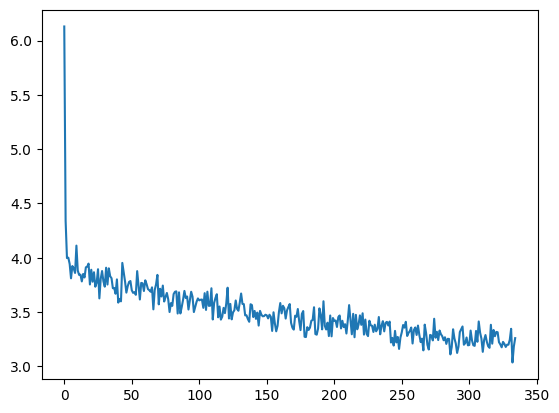

In [22]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(lossi[: len(lossi) // 50 * 50]).view(-1, 50).mean(dim=-1))
plt.show()